In [1]:
from graph_tool.all import *
from numba import njit
from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import random

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-fztzy3g1 because the default path (/home/user/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
#graph_household=load_graph('files/sub_graph_weekday_household_all.xml.gz')
graph_overall=load_graph('files/graphs/contact_network1_BFSsampled_5pc.xml.gz')
graph_overall2=load_graph('files/graphs/contact_network2_BFSsampled_5pc.xml.gz')

In [3]:
rg1 = Graph(graph_overall)
rg2 = Graph(graph_overall2)

In [4]:
rg1.vp['istate'] = rg1.new_vp('int', val=0)
rg2.vp['istate'] = rg2.new_vp('int', val=0)

In [5]:
print('Number of vertices/edges is {}/{}'.format(graph_overall.num_vertices(), graph_overall.num_edges()))

Number of vertices/edges is 587790/1466704


In [6]:
# NU- Network Update

class NU:
    def __init__(self, rg1):
        self.G=Graph(directed=False)
        self.G.add_vertex(rg1.num_vertices())
        self.l=[] # list of edges
        
    def get_updated_graph(self):
        return self.G
    
    def number_of_contacts(self):
        print(self.G.num_edges())
      
    def step(self, rg1, rg2):
        self.G.clear_edges()
        
        n, p= 1, 0.5
        f=np.random.binomial(n, p, rg1.num_edges())
        self.G.add_edge_list(rg1.get_edges()[f==1])
        
        f=np.random.binomial(n, p, rg2.num_edges())
        self.G.add_edge_list(rg2.get_edges()[f==1])

In [443]:
nu=NU(rg1)

In [446]:
start_time=time.time()
nu.step(rg1, rg2)
print(time.time()-start_time)
print(nu.get_updated_graph().num_edges())

0.44863414764404297
1452519


In [4]:
# graph_overall.save("files/my_graph.graphml")

In [5]:
#graph_household.ep['p'] = graph_household.new_ep('int', vals=None, val=0)
#graph_household.ep['purpose'] = graph_household.new_ep('int', vals=None, val=25)

In [6]:
#graph_overall.add_edge_list(graph_household.get_edges(eprops=[graph_household.ep['p'], graph_household.ep['purpose']]))

In [486]:
rg1.vp['istate']

0

In [495]:
random.random()

0.4565010894718379

In [541]:
I=[]

gamma=1/7
beta=0.05

# Initialize
rg1.vp['istate'].a=np.random.binomial(1, 1000/rg1.num_vertices(), size=rg1.num_vertices())

#print('before', sum(rg1.vp['istate'].a))
start_time=time.time()
cpt=0

list_of_infected=[]

def update(rg1):
    for a in rg1.get_vertices():
        if rg1.vp['istate'][a]==1:
            if random.random()<gamma:
                rg1.vp['istate'][a]=2

        elif rg1.vp['istate'][a]==0:
            ns=list(rg1.iter_all_neighbors(a))
            if len(ns)>0:
                for k in ns:
                    if rg1.vp['istate'][k]==1:
                        if random.random()<beta:
                            rg1.vp['istate'][a]=1
                            break


                            
def update2(rg1, day=0):
    cpt=0
    gamma=1/7
    beta=0.2

    for node in rg1.get_vertices():
        if rg1.vp['istate'][a]==1:
            if random.random()<gamma:
                rg1.vp['istate'][a]=2
    
    state=rg1.get_vertices(vprops=[rg1.vp.istate])[:,1]
    for edge, state_i, state_j in zip(rg1.get_edges(), state[x[:,0]], state[x[:,1]]):
        if (state_i==1 or state_j==1) & state_i!=state_j:
            if random.random()<beta:
                if state_i==1:
                    rg1.vp['istate'][edge[1]]=1
                else:
                    rg1.vp['istate'][edge[0]]=1
                    

        

start_time=time.time()

rg1.vp['istate'].a=np.random.binomial(1, 1000/rg1.num_vertices(), size=rg1.num_vertices())

for day in range(20):
    I.append(sum(rg1.vp['istate'].a==1))
    update2(rg1, day)
    print(day)
    
    
    
    
#print('after', sum(rg1.vp['istate'].a))
end_time=time.time()

print(end_time-start_time)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
104.75495529174805


In [27]:
from numba import prange


@njit(parallel=False)
def update2fast(node_labels, edges, day=0):
    cpt=0
    gamma=1/7
    beta=0.01
    
    # I->R
    f=(node_labels[:,1]==1)
    for node in node_labels[f]:
        if node[1]==1:
            if random.random()<gamma:
                node_labels[node[0], 1]=2 
                
    # S->I
    for edge, state_i, state_j in zip(edges, node_labels[edges[:,0],1], node_labels[edges[:,1],1]):
    #for i in range(edges.shape[0]):
        #edge=edges[i,:]
        #state_i=node_labels[edges[:,0],1][i,1]
        #state_j=node_labels[edges[:,1],1][i,1]
        
        #print(edge)
        #print(state_i)
        #print(state_j)
        
        
        if (state_i+state_j)==1:
            if random.random()<beta:
                if state_i==1:
                    node_labels[edge[1],1]=1
                else:
                    node_labels[edge[0],1]=1
                   


    return node_labels[:, 1]

def update2fast_ref(g, nb_days, s, beta=0.1, gamma=1/7):

    state = SIRState(g, beta=beta, gamma=gamma, s=g.vp['istate'])
    
    S, X, R = [], [], []

    print("ok")
    for t in range(nb_days):
        state.iterate_sync()
        sf = state.get_state().fa

                
        S.append((sf == 0).sum())
        X.append((sf == 1).sum())
        R.append((sf == 2).sum())
    return S, X, R

In [69]:
(np.array([1,2,3])<2)

array([ True, False, False])

In [28]:
# does not work correctly

@njit(parallel=False)
def update2fast_test_fast(node_labels, edges, day=0):
    cpt=0
    gamma=1/7
    beta=0.01
    
    # I->R
    f=(node_labels[:,1]==1)
    fa=(np.random.uniform(0, 1, size=len(f))<gamma)
    node_labels[f,:]=2
    

                
    # S->I
    #for edge, state_i, state_j in zip(edges, node_labels[edges[:,0],1], node_labels[edges[:,1],1]):
    
    A=node_labels[edges[:,0],1]
    B=node_labels[edges[:,1],1]
    
    f=((A+B)==1)
    
    sub_edges=edges[f]
    fa=(np.random.uniform(0, 1, size=len(f))<beta)
    sub_edges=sub_edges[fa]
    
    node_labels[sub_edges[:,0],1]=1
    node_labels[sub_edges[:,1],1]=1

    return node_labels[:, 1]

In [41]:
from numba import prange

@njit(parallel=True)
def update2fast_test(node_labels, edges, day=0):
    cpt=0
    gamma=1/7
    beta=0.2
    
    # I->R
    #f=(node_labels[:,1]==1)
    #for node in node_labels[f]:
    
    for i in prange(node_labels.shape[0]):
        if node_labels[i,1]==1:
            if random.random()<gamma:
                node_labels[i, 1]=2 
                
    # S->I
    #for edge, state_i, state_j in zip(edges, node_labels[edges[:,0],1], node_labels[edges[:,1],1]):
        
    for i in prange(edges.shape[0]):

        state_i=node_labels[edges[i,0],1]
        state_j=node_labels[edges[i,1],1]

        if (state_i+state_j)==1:
            if random.random()<beta:
                if state_i==1:
                    node_labels[edges[i,1],1]=1
                else:
                    node_labels[edges[i,0],1]=1
                   


    return node_labels[:, 1]

In [30]:
ibc=np.random.binomial(1, 1500/rg1.num_vertices(), size=rg1.num_vertices())
rg1.vp['istate'].a=ibc

start_time=time.time()
for k in range(150):
    rg1.vp['istate'].a=update2fast_test(rg1.get_vertices(vprops=[rg1.vp.istate]), rg1.get_edges())

print(time.time()-start_time)

5.30858039855957


In [10]:
rg1.get_edges()[0:10]

array([[     0, 351950],
       [     1,      2],
       [     1,      3],
       [     1,      4],
       [     2,      3],
       [     2,      4],
       [     3,      4],
       [     4, 391883],
       [     4, 576114],
       [     4, 583995]])

In [44]:
start_time=time.time()

#update2fast(rg1.get_vertices(vprops=[rg1.vp.istate]), rg1.get_edges())

S=[]
I=[]
R=[]


ibc=np.random.binomial(1, 1500/rg1.num_vertices(), size=rg1.num_vertices())
rg1.vp['istate'].a=ibc

beta=0.2
nb_days=150
with tqdm(total=nb_days, position=0, leave=True) as pbar: 
    for day in range(nb_days):
        #rg1.vp['istate'].a=update2fast(rg1.get_vertices(vprops=[rg1.vp.istate]), rg1.get_edges())
        rg1.vp['istate'].a=update2fast_test(rg1.get_vertices(vprops=[rg1.vp.istate]), rg1.get_edges())
        y=np.asarray(rg1.vp['istate'].a)

        S.append((y==0).sum())
        I.append((y==1).sum())
        R.append((y==2).sum())
        pbar.update(1)
    
end_time=time.time()

#print(end_time-start_time)

100%|██████████| 150/150 [00:05<00:00, 29.43it/s]


0.59 secs
ok
0.58 secs


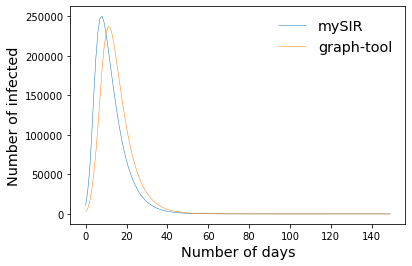

In [53]:
#plt.plot(S)
#plt.plot(R)

print(np.round(end_time-start_time,2),'secs')


# customized
plt.plot(I, lw=0.5, label='mySIR')
#plt.plot(S, lw=0.5)
#plt.plot(R, lw=0.5)


start_time=time.time()
# graph-tool
rg1.vp['istate'].a=ibc

S, Ig, R=update2fast_ref(rg1, nb_days, ibc, beta=beta, gamma=1/7)
end_time=time.time()
print(np.round(end_time-start_time,2),'secs')

plt.plot(Ig, lw=0.5, label='graph-tool')
plt.legend(fontsize='x-large', frameon=False)

plt.xlabel('Number of days', fontsize='x-large')
plt.ylabel('Number of infected', fontsize='x-large')

plt.savefig('files/validation_{}.jpg'.format(11), bbox_inches='tight', dpi=300)

plt.show()

In [507]:
print('in', end_time-start_time)

in 19.70157027244568


In [8]:
@njit
def track_status(sf, tracker, t):
    for k in np.where(sf==1)[0]: # loop over infected at day t
        if tracker[k,0]==0:
            tracker[k,0]=1
            tracker[k,1]=t # store day infection onset
                
    for k in np.where(sf==2)[0]: # loop over recovered at day t
        if tracker[k,0]==1:
            tracker[k,0]=0 # no more infectious
            tracker[k,2]=t # store day recovered
            
    return tracker
    

def run_SIR_with_snetwork2(g, nb_days, beta=0.1, gamma=1/7):

    # Discrete stochastic SIR/SEIR model

    # beta -> between 0.1 and 0.25
    #state = SIRState(g, beta=0.1, gamma=1/7, v0=graph_overall.vertex(0))
    state = SIRState(g, beta=beta, gamma=gamma, s=g.vp['istate'])
    
    S, X, R = [], [], []
    # tracker=np.zeros((g.num_vertices(),nb_days))
    tracker=np.zeros((g.num_vertices(), 3)) # flag/ start/ stop
    
    for t in range(nb_days):
        #state = SIRState(g, beta=0.1, gamma=1/7, s=s)
        ret = state.iterate_sync()
        sf = state.get_state().fa
        #tracker[:,t]=sf
        
        tracker=track_status(sf, tracker, t)
                
        S.append((sf == 0).sum())
        X.append((sf == 1).sum())
        R.append((sf == 2).sum())
    return S, X, R, tracker[:, [1,2]]  

def run_SIR_with_snetwork(g, nb_days, beta=0.1, gamma=1/7):

    # Discrete stochastic SIR/SEIR model

    # beta -> between 0.1 and 0.25
    #state = SIRState(g, beta=0.1, gamma=1/7, v0=graph_overall.vertex(0))
    state = SIRState(g, beta=beta, gamma=gamma, s=g.vp['istate'])
    
    S, X, R = [], [], []
    tracker=np.zeros((g.num_vertices(),nb_days))
    # tracker=np.zeros((g.num_vertices(), 3)) # flag/ start/ stop
    
    for t in range(nb_days):
        #state = SIRState(g, beta=0.1, gamma=1/7, s=s)
        ret = state.iterate_sync()
        sf = state.get_state().fa
        tracker[:,t]=sf
        

                
            
                
        
        S.append((sf == 0).sum())
        X.append((sf == 1).sum())
        R.append((sf == 2).sum())
    return S, X, R, tracker     

def run_SIR_with_dnetwork(g, nb_days=100, gopt=None, beta=0.1, gamma=1/7):

    # Discrete stochastic SIR/SEIR model with time-varying network
    # beta -> between 0.1 and 0.25
    
    S, X, R = [], [], []
    
    tracker=np.zeros((g.num_vertices(), 3)) # flag/ start/ stop
    
    if gopt!=None:
        nu=NU(g)
    
    for t in range(nb_days):
        if t==0:
            state = SIRState(g, beta=beta, gamma=gamma, s=g.vp['istate'])
        else:
            if gopt!=None:
                nu.step(g, gopt)
                state = SIRState(nu.get_updated_graph(), beta=beta, gamma=gamma, s=sf)
            else:
                state = SIRState(g, beta=beta, gamma=gamma, s=sf)

        state.iterate_sync()
        sf = state.get_state()
        
        tracker=track_status(sf.fa, tracker, t)

        # Store results
        S.append((sf.fa == 0).sum())
        X.append((sf.fa == 1).sum())
        R.append((sf.fa == 2).sum())
        
    return S, X, R, tracker[:, [1,2]]   


@njit
def get_new_daily_infections(tracker, nb_days, nb_inds):
    cpt=0
    list_of_new_infections=[]
    for day in range(nb_days-1):
        for idv in range(nb_inds):
            if (tracker[idv,day+1]==1) and (tracker[idv,day]==0):
                cpt+=1

        list_of_new_infections.append(cpt)
        cpt=0
    return list_of_new_infections

In [87]:
#u = GraphView(graph_overall, vfilt= (graph_overall.ep['purpose'].a==1))
#sub_graph_overall = Graph(u, prune=True)

In [9]:
# TEST

nb_trials=2
start_time=time.time()
with tqdm(total=nb_trials, position=0, leave=True) as pbar: 
    for k in range(nb_trials):  
        S, X, R, subtracker=run_SIR_with_snetwork2(rg1, nb_days, beta, gamma)
        pbar.update(1)
        
print('Time needed is {}'.format(time.time()-start_time))

  0%|          | 0/2 [00:00<?, ?it/s]


NameError: name 'nb_days' is not defined

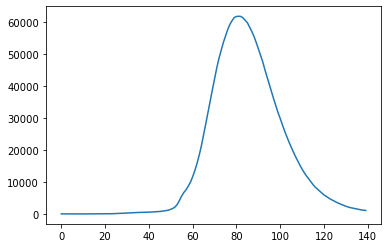

In [456]:
plt.plot(X)

In [11]:
@njit
def get_new_daily_infections_new(nb_days, subtracker):

    timeline=np.zeros((nb_days,))

    for k,l in zip(subtracker[:,0],subtracker[:,1]):
        f=np.int64(k)
        if k==0 and l==0:
            timeline[f]+=0
        else:
            timeline[f]+=1

    return timeline

100%|██████████| 800/800 [02:22<00:00,  5.60it/s]


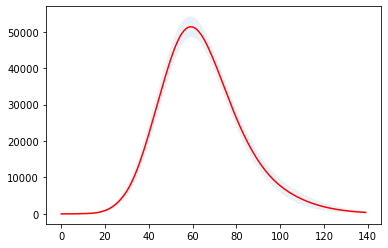

In [20]:
R0=12 # omicron 12_15
nb_days=140
nb_trials=100
beta=(0.065+0.067)/2 # because of masks+vaccines
gamma=1/7


vals=np.random.binomial(1, 5/graph_overall.num_vertices(), size=graph_overall.num_vertices())
graph_overall.vp['istate'] = graph_overall.new_vp('int', vals=vals)

curves_X=np.zeros((nb_trials, nb_days))
curves_S=np.zeros((nb_trials, nb_days))
curves_infections=np.zeros((8, nb_days))
curves_infections_total=np.zeros((nb_days,))

#tracker=np.zeros((graph_overall.num_vertices(), nb_days, 8))

with tqdm(total=nb_trials*8, position=0, leave=True) as pbar: 
    for k in range(nb_trials):  
        S, X, R, subtracker=run_SIR_with_snetwork2(graph_overall, nb_days, beta, gamma)
        #ax.plot(X, label="Infectious", alpha=0.1, color='blue')
        curves_X[k, :]=np.asarray(X)
        curves_S[k, :]=np.asarray(S)
        curves_infections_total+=np.asarray(get_new_daily_infections_new(nb_days, subtracker))

        #f=np.where(curves.sum(axis=1)<100)
        
        
        # compute new daily infections + averaging
        for i, refdep in zip(np.arange(8), [75, 92, 93, 94, 91, 95, 77, 78]):
            #tracker_pdep=tracker[:,:,i].reshape((graph_overall.num_vertices(), nb_days))
            tracker_pdep=subtracker[np.asarray(graph_overall.vp['dep'].a==refdep)]
            #curves_infections[i,:]+=np.asarray(get_new_daily_infections(tracker_pdep, nb_days, tracker_pdep.shape[0]))/tracker_pdep.shape[0]*10**5
            curves_infections[i,:]+=np.asarray(get_new_daily_infections_new(nb_days, tracker_pdep))/tracker_pdep.shape[0]*10**5
            pbar.update(1)

#curves_X=np.delete(curves_X, f, axis=0)
#curves_S=np.delete(curves_S, f, axis=0)

#plt.plot(curves.T, color='gray', alpha=0.1)
plt.plot(curves_X.T.mean(axis=1), color='red')

plt.fill_between(np.arange(nb_days), 
                y1=curves_X.T.mean(axis=1)-1.96*curves_X.T.std(axis=1)/np.sqrt(curves_X.shape[0]), 
                y2=curves_X.T.mean(axis=1)+1.96*curves_X.T.std(axis=1)/np.sqrt(curves_X.shape[0]), 
                alpha=0.1, 
                label='CI 95%')
plt.show()

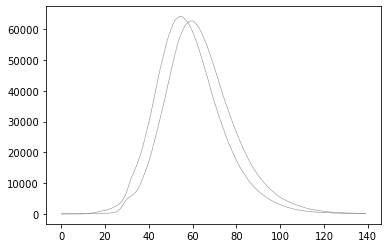

In [15]:
plt.plot(curves_X.T, color='gray', lw=0.5)
plt.show()

In [16]:
df=pd.read_csv('sp-pe-tb-quot-dep-2022-04-24-19h00.csv',';')

# df.head()
#df=pd.read_csv('https://static.data.gouv.fr/resources/taux-dincidence-de-lepidemie-de-covid-19/20220228-190529/sp-pe-tb-quot-dep-2022-02-28-19h05.csv',';')

/usr/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [195]:
#dfs=pd.DataFrame([(k[0], k[1]['P'].sum()) for k in df[df['dep'].isin([75, 92, 93, 94, 91, 95, 77, 78])][['jour','P']].groupby('jour')], columns=['date','nb']).set_index('date')

In [19]:
#curves_infections=np.zeros((1, nb_days-1))

#for k in range(nb_trials):
#    tracker_pdep=tracker[:,:,k][np.asarray(graph_overall.vp['dep'].a==refdep)]
#    curves_infections[k,:]=np.asarray(get_new_daily_infections(tracker_pdep, nb_days, tracker_pdep.shape[0]))

In [20]:
#plt.plot(curves_infections.T, color='gray', lw=0.1)

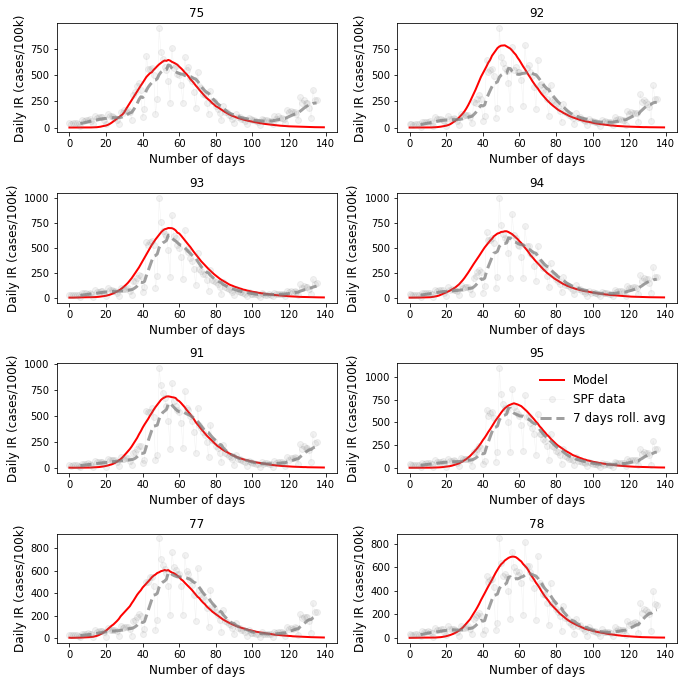

In [26]:
refdep=78

scale=.8
ncols=2
nrows=4
fig, axs=plt.subplots(figsize=(ncols*scale*6, nrows*scale*3), tight_layout=True, ncols=ncols, nrows=nrows)

#plt.plot(curves.T, color='blue', alpha=0.1)
#plt.plot(curves.T.mean(axis=1), color='red')

#ax.fill_between(np.arange(nb_days), 
#                y1=curves.T.mean(axis=1)-1.96*curves.T.std(axis=1)/np.sqrt(curves.shape[0]), 
#                y2=curves.T.mean(axis=1)+1.96*curves.T.std(axis=1)/np.sqrt(curves.shape[0]), 
#                alpha=0.1, 
#                label='CI 95%')

#ax.plot(curves.T.mean(axis=1), '--',lw=1.5, label='On-going infected')


for refdep, ax, i in zip([75, 92, 93, 94, 91, 95, 77, 78], axs.reshape((-1,)), np.arange(8)):
    
    #popsize_dep=np.sum(np.asarray(graph_overall.vp['dep'].a==refdep))
    #tracker_pdep=tracker[np.asarray(graph_overall.vp['dep'].a==refdep)]
    #list_of_new_infections=get_new_daily_infections(tracker_pdep, nb_days, tracker_pdep.shape[0])
    
    
    
    x=2/3*0.75*curves_infections[i,:]/nb_trials        
    #tracker_pdep=tracker[:,:,k][np.asarray(graph_overall.vp['dep'].a==refdep)]
    
    #x=1/2*0.7*np.asarray(list_of_new_infections)/(tracker_pdep.shape[0])*10**5
    ax.plot(x, '-',label='Model', lw=2., color='red')
    #ax.fill_between(np.arange(len(x)), 
    #            y1=curves.T.mean(axis=1)-1.96*curves.T.std(axis=1)/np.sqrt(curves.shape[0]), 
    #            y2=curves.T.mean(axis=1)+1.96*curves.T.std(axis=1)/np.sqrt(curves.shape[0]), 
    #            alpha=0.1, 
    #            label='CI 95%')
    
    
    #offset=-72
    #n=-(offset+1)



    # filter by department
    #which_dep=[75, 92, 93, 94, 91, 95, 77, 78]
    which_dep=[refdep]
    #dfs=pd.DataFrame([(k[0], k[1]['P'].sum()) for k in df[df['dep'].isin(which_dep)][['jour','P']].groupby('jour')], columns=['date','nb']).set_index('date')
    dfs=pd.DataFrame([(k[0], k[1]['P'].sum(), k[1]['pop'].sum(), 10**5*k[1]['P'].sum()/k[1]['pop'].sum()) for k in df[df['dep'].isin(which_dep)][['jour','P','pop']].groupby('jour')], columns=['date','pos','pop','ti']).set_index('date')

    ax.plot(dfs.loc['2021-11-15':'2022-03-30']['ti'].values, '-o', lw=.5, color='gray', alpha=0.1, label='SPF data')
    ax.plot(dfs.loc['2021-11-15':'2022-03-30']['ti'].rolling(window=7).mean().values, '--',label='7 days roll. avg', color='gray', lw=3., alpha=.75)


    #ax.grid(True, lw=0.1)
    #ax.plot(R, label="Recovered")
    ax.set_xlabel(r"Number of days", fontsize='large')
    ax.set_ylabel(r"Daily IR (cases/100k)", fontsize='large')
    
    if refdep==95:
        ax.legend(loc="best",  fontsize='large', frameon=False)
    # ax.grid(True, lw=0.1)
    # ax.set_yticks(np.linspace(0, 200000, 5))
    # ax.set_xlim(40, 100)
    ax.set_title(refdep)

#fig.savefig('figure.jpg', bbox_inches='tight', dpi=400)
fig.savefig('files/validation_{}.jpg'.format(10), bbox_inches='tight', dpi=300)

plt.show()

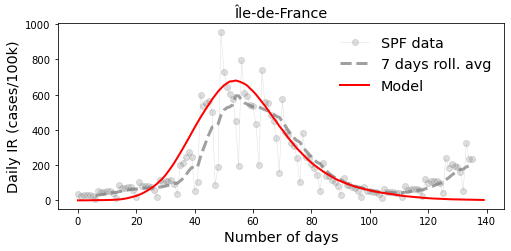

In [25]:
scale=1.2
fig, ax=plt.subplots(figsize=(6*scale, 3*scale), tight_layout=True)

which_dep=[75, 92, 93, 94, 91, 95, 77, 78]
#which_dep=[refdep]
#dfs=pd.DataFrame([(k[0], k[1]['P'].sum()) for k in df[df['dep'].isin(which_dep)][['jour','P']].groupby('jour')], columns=['date','nb']).set_index('date')

dfs=pd.DataFrame([(k[0], 
                   k[1]['P'].sum(), 
                   k[1]['pop'].sum(), 
                   10**5*k[1]['P'].sum()/k[1]['pop'].sum()) for k in df[df['dep'].isin(which_dep)][['jour','P','pop']].groupby('jour')], columns=['date','pos','pop','ti']).set_index('date')

ax.plot(dfs.loc['2021-11-15':'2022-03-30']['ti'].values, '-o', lw=.5, color='gray', alpha=0.25, label='SPF data')
ax.plot(dfs.loc['2021-11-15':'2022-03-30']['ti'].rolling(window=7).mean().values, '--',label='7 days roll. avg', color='gray', lw=3., alpha=.75)

ax.plot(2/3*0.75*curves_infections_total/nb_trials/graph_overall.num_vertices()*10**5, color='red', lw=2., label='Model')
ax.legend(fontsize='x-large', frameon=False)
ax.set_xlabel(r"Number of days", fontsize='x-large')
ax.set_ylabel(r"Daily IR (cases/100k)", fontsize='x-large')
ax.set_title('Île-de-France', fontsize='x-large')

fig.savefig('files/validation_{}.jpg'.format(9), bbox_inches='tight', dpi=300)

plt.show()

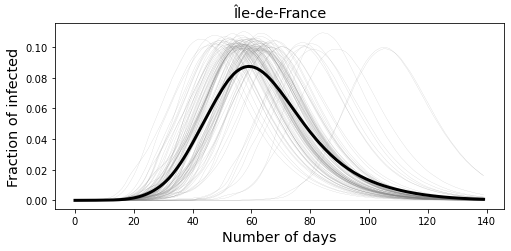

In [24]:
scale=1.2
fig, ax=plt.subplots(figsize=(6*scale, 3*scale), tight_layout=True)


ax.plot(curves_X.T/graph_overall.num_vertices(), color='gray', lw=.1)
ax.plot(curves_X.mean(axis=0)/graph_overall.num_vertices(), color='black', lw=3.)

#ax.plot(curves_S.T/graph_overall.num_vertices(), color='blue', lw=.1)
#ax.plot(curves_S.mean(axis=0)/graph_overall.num_vertices(), color='blue', lw=3.)


#ax.legend(fontsize='x-large', frameon=False)
ax.set_xlabel(r"Number of days", fontsize='x-large')
ax.set_ylabel(r"Fraction of infected", fontsize='x-large')
ax.set_title('Île-de-France', fontsize='x-large')

fig.savefig('files/validation_{}.jpg'.format(8), bbox_inches='tight', dpi=300)

plt.show()